<a href="https://colab.research.google.com/github/junheeyoon/colab/blob/main/5_2_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 환경 세팅

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 데이터 다운로드


In [ ]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
!mv "/content/nsmc" "/content/drive/My Drive/데이터분석/nsmc"

# 2. 데이터 탐색

In [ ]:
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/3days_ml/')

In [ ]:
path_to_data = "/content/drive/My Drive/데이터분석/nsmc/ratings.txt"
df = pd.read_table(path_to_data)

In [ ]:
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


라벨 기준 데이터 수 확인

In [ ]:
df['label'].value_counts()

1    100000
0    100000
Name: label, dtype: int64

In [ ]:
df['document'].str.len().sort_values()

90561     1.0
146968    1.0
16740     1.0
191185    1.0
28214     1.0
         ... 
84098     NaN
127017    NaN
172375    NaN
173526    NaN
197279    NaN
Name: document, Length: 200000, dtype: float64

입력 데이터 Null 확인 및 제거

In [ ]:
df['document'].isnull().sum()

8

In [ ]:
df.dropna(inplace=True)

문장 길이별 데이터 빈도수

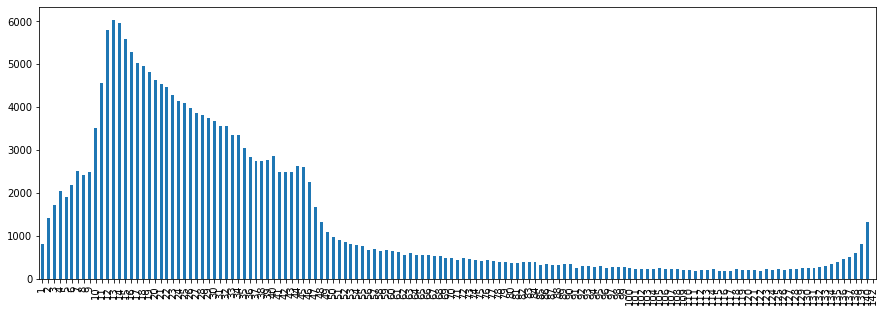

In [ ]:
df['document'].str.len().value_counts().sort_index().plot(kind='bar',figsize=(15,5))

길이가 짧은 입력 데이터 확인.

길이가 짧을 수록 비문(?)인 경우가 많은 것을 유추할 수 있음.
짧은 길이의 데이터도 (ex>ㅋ) 분석 및 학습대상에 포함을 시켜야 할지 고민해야함.


In [ ]:
df.loc[df['document'].str.len() <= 1,'document'].value_counts()

굿    237
굳     77
.     67
짱     53
ㅋ     49
    ... 
꽉      1
로      1
진      1
허      1
웅      1
Name: document, Length: 124, dtype: int64

전처리

특수문자 확인

In [ ]:
sp_char = df['document'].str.replace('[a-zA-Zㄱ-ㅎㅏ-ㅢ가-힣0-9]','').str.replace(" ",'')

In [ ]:
import itertools 
sp_char = "".join(itertools.chain(sp_char.values))

In [ ]:
tmp = []
for i in np.unique(sp_char)[0]:
  if i not in tmp:
    tmp.append(i)

특수문자 제거

In [ ]:
df['clean'] = df['document'].str.replace('[^a-zA-Zㄱ-ㅎㅏ-ㅢ가-힣0-9 ]','')

In [ ]:
df[['document','clean']].head()

,document,clean
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,어릴때보고 지금다시봐도 재밌어요ㅋㅋ
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음 최고
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화


In [ ]:
df = df.loc[df['clean'].str.len() >= 1].reset_index(drop=True)

데이터 길이 cut-off

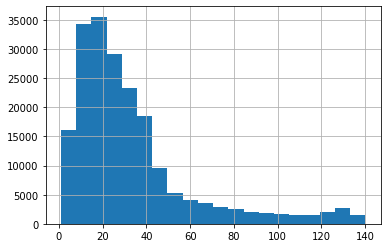

In [ ]:
df['clean'].str.len().hist(bins=20)

In [ ]:
df['clean'].str.len().mean(), \
df['clean'].str.len().std()

(32.85124927367809, 28.27766949418672)

In [ ]:
threshold = round(df['clean'].str.len().mean() - 0.5*df['clean'].str.len().std())

In [ ]:
df_cutoff = df.loc[df['clean'].str.len() >= 19]

In [ ]:
df_cutoff.shape

(127730, 4)

# 3. 형태소 분석기
1. konlpy: KoNLP의 Python 버전



In [ ]:
!pip3 install konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 460kB 45.6MB/s 
     |████████████████████████████████| 92kB 13.0MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from konlpy.tag import Okt
okt = Okt()
okt.pos("안녕, 세상.")

[('안녕', 'Noun'), (',', 'Punctuation'), ('세상', 'Noun'), ('.', 'Punctuation')]

2. Khaiii: 카카오에서 개발한 형태소 분석기

  

In [ ]:
# !git clone https://github.com/kakao/khaiii.git

# !pip install cmake

# !mkdir build

!cd build && cmake /content/khaiii

!cd /content/build/ && make all

!cd /content/build/ && make resource

!cd /content/build && make install

!cd /content/build && make package_python

!pip install /content/build/package_python

In [ ]:
from khaiii import KhaiiiApi
api = KhaiiiApi()
for word in api.analyze("안녕, 세상."):
    print(word)

데이터 샘플 추출

In [ ]:
df_samp = pd.concat([
  df_cutoff.loc[df_cutoff['label'] == 0].sample(10000, random_state=1234),
  df_cutoff.loc[df_cutoff['label'] == 1].sample(10000, random_state=1234)           
])


형태소 분석

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()

In [ ]:
token = []
for sentence in df_samp['clean']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    token.append(temp_X)

In [ ]:
df_samp['token'] = pd.Series(token).str.join(" ").values

In [ ]:
df_samp.head()

,id,document,label,clean,token
180795,9306323,하나 같이 연기를 못해서.. 무표정이 더 무서웠다 ㅡㅡ 역.대.급. 최악. 영화.,0,하나 같이 연기를 못해서 무표정이 더 무서웠다 ㅡㅡ 역대급 최악 영화,하나 같이 연기 못 무표정 더 무섭다 ㅡㅡ 역대 급 최악 영화
186719,8425831,10점들 다 알바인가요? 진짜 이만큼 의도를 모르겠고 내용도 조잡하고 이런 영화는 ...,0,10점들 다 알바인가요 진짜 이만큼 의도를 모르겠고 내용도 조잡하고 이런 영화는 처...,10 점 다 알바 인가요 진짜 만큼 의도 모르다 내용 조잡하다 이렇다 영화 처음 임...
155875,6963836,재미없엇다 좀 지루햇지만 그래도 보는데 나쁘진않앗다,0,재미없엇다 좀 지루햇지만 그래도 보는데 나쁘진않앗다,재미없다 지루 햇 지만 그래도 보다 나쁘다 않다
177772,7459535,아무리 코믹영화라지만 인간이 다 저렇게 단순한가? 등장인물 성격이 다 똑같고 사건이...,0,아무리 코믹영화라지만 인간이 다 저렇게 단순한가 등장인물 성격이 다 똑같고 사건이 ...,아무리 코믹 영화 라지 만 인간 다 저렇게 단순하다 등장인물 성격 다 똑같다 사건 ...
135760,4768148,당시엔 획기적이었겠지만 25년후인 지금 보기엔 많이 어설프다.. 7점,0,당시엔 획기적이었겠지만 25년후인 지금 보기엔 많이 어설프다 7점,당시 엔 획기 적 이다 25년 후인 지금 보기 엔 많이 어설프다 7 점


# 4. 기계학습

### 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_samp['clean'], df_samp['label'], stratify=df_samp['label'])

### Pipeline

In [ ]:
vect = CountVectorizer(max_features=1000)
tfidf = TfidfTransformer()

clf1 = neighbors.KNeighborsClassifier()
clf2 = naive_bayes.BernoulliNB()
clf3 =  ensemble.RandomForestClassifier()

cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 1234 ) # run model 10x with 60/30 split intentionally leaving out 10%

In [ ]:
scores = []
for clf in [clf1, clf2, clf3]:
  print(clf)
  pipeline =  Pipeline([('vect',vect),
                        ('tfidf',tfidf),
                        ('clf',clf)])
  
  pipeline.fit(X_train, y_train)
  y_preds = pipeline.predict(X_test)
  print(f1_score(y_test, y_preds, average='micro'))
  print(cross_val_score(pipeline,df_samp['clean'],df_samp['label'],cv=5,scoring='f1_micro'))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
0.6599686847599165
[0.6195  0.62475 0.62175 0.62125 0.628  ]
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
0.7338204592901879
[0.72875 0.7225  0.724   0.71925 0.73325]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.7187891440501044
[0.69375 0.69575 0.691   0.68425 0.6975 ]


In [ ]:
scores = []
for clf in [clf1, clf2, clf3]:
  print(clf)
  pipeline =  Pipeline([('vect',vect),
                        ('tfidf',tfidf),
                        ('clf',clf)])
  
  pipeline.fit(X_train, y_train)
  y_preds = pipeline.predict(X_test)
  print(f1_score(y_test, y_preds, average='micro'))
  print(cross_val_score(pipeline,df_samp['token'],df_samp['label'],cv=5,scoring='f1_micro'))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
0.6599686847599165
[0.5745  0.6065  0.592   0.59025 0.59725]
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
0.7338204592901879
[0.79425 0.797   0.80425 0.79175 0.803  ]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.7198851774530272
[0.76775 0.77975 0.771   0.7665  0.783  ]


### 파라미터 최적화

In [ ]:
prep =  Pipeline([('vect',vect), ('tfidf',tfidf)])

In [ ]:
X = prep.fit_transform(df_samp['token'])
y = df_samp['label'].values

In [ ]:
grid_param = [
  # KN              
  [{'leaf_size':[10, 20, 30], 'n_neighbors':[3, 5, 7]}],
  # NB
  [{'alpha': [0.1, 0.5, 1.0]}],
  # SVM
  [{'n_estimators': [5, 10, 20]}]
]
clfs = [clf1, clf2, clf3]

In [ ]:
import time
from sklearn import model_selection
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

start_total = time.perf_counter()
for clf, param in zip (clfs, grid_param):    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf, param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(X,y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf.__class__.__name__, best_param, run))
    clf.set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for KNeighborsClassifier is {'leaf_size': 10, 'n_neighbors': 3} with a runtime of 63.94 seconds.
The best parameter for BernoulliNB is {'alpha': 1.0} with a runtime of 0.15 seconds.
The best parameter for RandomForestClassifier is {'n_estimators': 20} with a runtime of 16.80 seconds.
Total optimization time was 1.35 minutes.
----------


In [ ]:
vote_hard = ensemble.VotingClassifier(estimators = [(i.__class__.__name__, i) for i in clfs], voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X, y, cv  = cv_split, return_train_score = True)
vote_hard.fit(X, y)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))

Hard Voting Training w/bin score mean: 93.84
Hard Voting Test w/bin score mean: 78.41
Hard Voting Test w/bin score 3*std: +/- 1.64


In [ ]:
vote_soft = ensemble.VotingClassifier(estimators = [(i.__class__.__name__, i) for i in clfs], voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_hard, X, y, cv  = cv_split, return_train_score = True)
vote_soft.fit(X, y)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))

Soft Voting Training w/bin score mean: 93.88
Soft Voting Test w/bin score mean: 78.28
Soft Voting Test w/bin score 3*std: +/- 1.20


# 6. RNN

### 전처리

데이터 분할

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_samp['clean'], df_samp['label'], test_size=0.3, stratify=df_samp['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((14000,), (3000,), (3000,))

TF를 이용한 토크나이즈

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_samp['token'])

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 20961
등장 빈도가 2번 이하인 희귀 단어의 수: 13006
단어 집합에서 희귀 단어의 비율: 62.04856638519155
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.408358096569899
단어 집합의 크기 : 7957


In [ ]:
X_train.head()

16438             보기드문 중국 리얼리즘 영화 산업자본화되어가는 중국의 명암을 잘 나타낸 듯
90618     독일 바그다드 카페 일본의 카모메 식당 이 생각나네요 일본에서 상을 주는 이유를 알...
140626                                  아쉽다지루하다어이없다이건아니잔나정말
42219     최고 가슴이 먹먹해지고 영상도너무좋고 여운이남는영화마지막 황제가 하는 대사는 아직도...
106946                배부른 휴먼드라마로 시작해 기시감 가득한 헐리웃 멜로드라마로 마무리
Name: clean, dtype: object

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(df_samp['token'])

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)


In [ ]:
X_train[:5]

[[1, 821, 6550, 2, 1, 1, 1, 1, 1, 128],
 [3235, 1, 1, 1, 1, 4525, 1, 1, 1, 1, 1, 1, 1, 1, 886, 1, 1],
 [1],
 [48, 1, 1, 1, 1, 1, 1, 1, 358, 1],
 [1, 1, 1, 1, 1, 1548, 1, 796]]

In [ ]:
print(tokenizer.word_index)

{'OOV': 1, '영화': 2, '보다': 3, '을': 4, '없다': 5, '있다': 6, '이다': 7, '좋다': 8, '너무': 9, '다': 10, '적': 11, '정말': 12, '되다': 13, '같다': 14, '만': 15, '아니다': 16, '진짜': 17, '로': 18, '않다': 19, '에서': 20, '점': 21, '만들다': 22, '재밌다': 23, '것': 24, '연기': 25, '나오다': 26, '평점': 27, '그': 28, '생각': 29, '인': 30, '내': 31, '안': 32, '사람': 33, '못': 34, '스토리': 35, '나': 36, '보고': 37, '고': 38, '드라마': 39, '때': 40, '왜': 41, '배우': 42, '더': 43, '게': 44, '감동': 45, '이렇다': 46, '감독': 47, '최고': 48, '1': 49, '내용': 50, '말': 51, '주다': 52, '그냥': 53, '까지': 54, '거': 55, '하고': 56, '자다': 57, '아깝다': 58, '아': 59, '수': 60, 'ㅋㅋ': 61, '중': 62, '재미': 63, '가다': 64, '요': 65, '모르다': 66, '들다': 67, '재미있다': 68, '지루하다': 69, '그렇다': 70, '시간': 71, '알다': 72, '뭐': 73, '사랑': 74, '작품': 75, '싶다': 76, '네': 77, '쓰레기': 78, '하나': 79, '지': 80, '재미없다': 81, '마지막': 82, '저': 83, '다시': 84, '오다': 85, '많다': 86, '정도': 87, '처음': 88, '10': 89, '주인공': 90, '볼': 91, '이렇게': 92, '장면': 93, '이야기': 94, '이건': 95, '안되다': 96, '액션': 97, '연출': 98, '2': 99, '걸': 100, '완전': 101, '나다':

길이 0 인 문장 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_val = [index for index, sentence in enumerate(X_val) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

X_val = np.delete(X_val, drop_val, axis=0)
y_val = np.delete(y_val, drop_val, axis=0)

X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((14000,), (3000,), (3000,))

패딩: max length에 맞추어 길이 통일

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))

리뷰의 최대 길이 : 39


In [ ]:
max_len = 39
X_train = pad_sequences(X_train, maxlen = max_len)
X_val = pad_sequences(X_val, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 모델

In [ ]:
many_to_one = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100),
    tf.keras.layers.LSTM(128,  return_sequences=False),
    tf.keras.layers.Dense(1)
])

many_to_one.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(1e-4),
              metrics=['accuracy'])

many_to_one.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         795700    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 913,077
Trainable params: 913,077
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = many_to_one.fit(X_train, y_train.values, epochs=10, validation_data=(X_val, y_val.values))

Epoch 1/10
438/438 [==============================] - 9s 21ms/step - loss: 0.6923 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 2/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6812 - accuracy: 0.5026 - val_loss: 0.6698 - val_accuracy: 0.5240
Epoch 3/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6504 - accuracy: 0.5489 - val_loss: 0.6428 - val_accuracy: 0.5507
Epoch 4/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6269 - accuracy: 0.5868 - val_loss: 0.6398 - val_accuracy: 0.5560
Epoch 5/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6093 - accuracy: 0.6119 - val_loss: 0.6210 - val_accuracy: 0.5870
Epoch 6/10
438/438 [==============================] - 9s 20ms/step - loss: 0.5946 - accuracy: 0.6327 - val_loss: 0.6108 - val_accuracy: 0.5997
Epoch 7/10
438/438 [==============================] - 9s 20ms/step - loss: 0.5813 - accuracy: 0.6471 - val_loss: 0.6060 - val_accuracy: 0.6177

### 학습 시각화

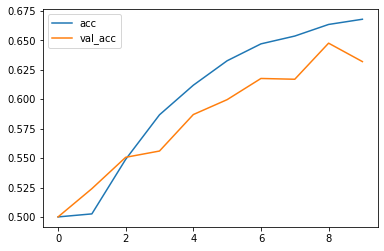

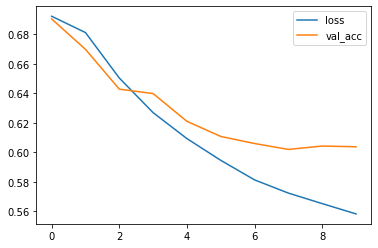

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame({'acc':history.history['accuracy'], 'val_acc':history.history['val_accuracy']}).plot()
pd.DataFrame({'loss':history.history['loss'], 'val_acc':history.history['val_loss']}).plot()




### 예측

In [ ]:
# test accuracy
y_pred = pd.Series(many_to_one.predict(X_test).reshape(-1,)).map(lambda x: 1 if x>0 else 0)
np.mean(y_pred.values == y_test.values)

0.6603333333333333

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(many_to_one.predict(pad_new)) # 예측
  if(score > 0):
    print("긍정 리뷰입니다")
  else:
    print("부정 리뷰입니다")

In [ ]:
sentiment_predict('이 영화 개노잼')

부정 리뷰입니다


In [ ]:
sentiment_predict('이 영화 개꿀잼')

긍정 리뷰입니다


# CNN

### 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
embedding_dim = 256
batch_size = 256

many_to_one = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100),
    tf.keras.layers.LSTM(128,  return_sequences=False),
    tf.keras.layers.Dense(1)
])


In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, 256),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Conv1D(256, 3, padding='valid', activation='relu'),
      tf.keras.layers.GlobalMaxPooling1D(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 256)         2036992   
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [ ]:
history = model.fit(X_train, y_train.values, epochs=10, validation_data=(X_val, y_val.values))

Epoch 1/10
438/438 [==============================] - 9s 21ms/step - loss: 0.6964 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 6/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6828 - accuracy: 0.5408 - val_loss: 0.6781 - val_accuracy: 0.5853
Epoch 7/10
438/438 [==============================] - 9s 20ms/step - loss: 0.6597 - accuracy: 0.6247 - val_loss: 0.6650 - val_accuracy: 0.6277

### 학습시각화

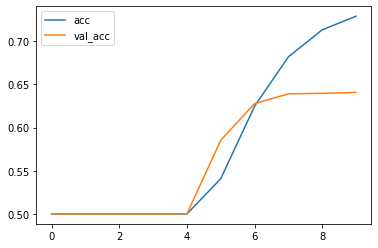

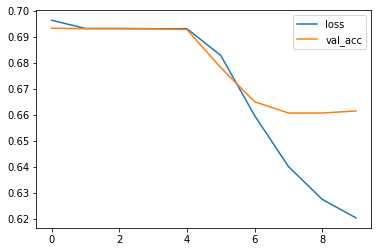

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame({'acc':history.history['accuracy'], 'val_acc':history.history['val_accuracy']}).plot()
pd.DataFrame({'loss':history.history['loss'], 'val_acc':history.history['val_loss']}).plot()

### 예측

In [ ]:
# test accuracy
y_pred = pd.Series(model.predict(X_test).reshape(-1,)).map(lambda x: 1 if x>0 else 0)
np.mean(y_pred.values == y_test.values)

0.5

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  print(score)
  if(score > 0.5):
    print("긍정 리뷰입니다")
  else:
    print("부정 리뷰입니다")

In [ ]:
sentiment_predict('이 영화 개노잼')

0.0009645057725720108
부정 리뷰입니다


In [ ]:
sentiment_predict('이 영화 개꿀잼')

0.8085392713546753
긍정 리뷰입니다
